In [1]:
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
# import tensorflow_probability as tfp
import gpflow
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.metrics import *

sys.path.append('../../mogp_decomposition/')
from mwgp import GPD

np.random.seed(11111986)
tf.set_random_seed(11111986)

/home/ubuntu/anaconda3/envs/mogp-dev/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/mogp-dev/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/mogp-dev/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/mogp-dev/lib

In [2]:
js_dat = pd.read_csv(
    '../../data/Jester/jesterfinal151cols.CSV', 
    sep=';', 
    header=None, 
    na_values='99', 
    index_col=0, 
    decimal=',',
    dtype='float32')
js_dat = js_dat.values
nonna_ids = np.where(~np.isnan(js_dat))
nonna_values = js_dat[nonna_ids]
js_triple_store_ids = np.hstack([nonna_ids[0][:, None], nonna_ids[1][:, None]])
js_triple_store_values = nonna_values

In [3]:
js_triple_store_values.max()

10.0

In [4]:
N = js_triple_store_ids.shape[0]

ids = np.random.choice(np.arange(N), N, replace=False)
splits = np.array_split(ids, 5)


read_in = open('../../data/Jester/splits.pkl', 'rb')
splits = pickle.load(read_in)
read_in.close()


In [5]:
Y_te_list = []
pred_list = []
pred_var_list = []
pred_sd_list = []

In [6]:
for cv_id in range(5): 
    te_ids = splits[cv_id]
    tr_ids = []
    for i in range(len(splits)): 
        if i != cv_id: 
            tr_ids.append(splits[i])
    tr_ids = np.concatenate(tr_ids)

    X_tr = js_triple_store_ids[tr_ids][:, 0:2]
    Y_tr = js_triple_store_values[tr_ids]

    X_te = js_triple_store_ids[te_ids][:, 0:2]
    Y_te = js_triple_store_values[te_ids]
    Y_te_list.append(Y_te)

    I = js_triple_store_ids[:, 0].max()+1
    J = js_triple_store_ids[:, 1].max()+1
    K = None

    hyper_params = {'I':I, 'J':J, 'K':K,
                    'emb_sizes': [8, 8], 
                    'M': 128, 
                    'emb_reg': 1e-4,
                    'batch_size': 2**16, 
                    'obs_mean': Y_tr.mean(), 
                    'lr': 1e-2}
    gp_md = GPD(**hyper_params)
    gp_md.save_path = './jester_cv'+str(cv_id)+'/'
    gp_md.build()
    gp_md.load_params()
    
    pred, pred_var = gp_md.predict(X_te)
    pred = pred.reshape(-1)
    pred_var = pred_var.reshape(-1)
    pred_sd = pred_var**.5
    # print(mean_absolute_error(y_true=Y_te, y_pred=y_pred))
    # print(mean_squared_error(y_true=Y_te, y_pred=y_pred)**.5)

    pred_list.append(pred)
    pred_var_list.append(pred_var)
    pred_sd_list.append(pred_sd)
    
    

Build SVGP



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Build SVGP
Build SVGP
Build SVGP
Build SVGP


In [7]:
qs = np.arange(.1, 1.1, 0.1)

In [8]:
maes_list = []
rmses_list = []

for j in range(5): 
    maes = np.zeros(10)
    rmses = np.zeros(10)
    for i in range(10):
        this_q = qs[i]
        thresh = np.quantile(pred_sd_list[j], this_q)
        inds = np.where(pred_sd_list[j] <= thresh)[0]
        maes[i] = mean_absolute_error(y_true=Y_te_list[j][inds], y_pred=pred_list[j][inds])
        rmses[i] = mean_squared_error(y_true=Y_te_list[j][inds], y_pred=pred_list[j][inds])**.5
    maes_list.append(maes)
    rmses_list.append(rmses)

In [9]:
sns.set()

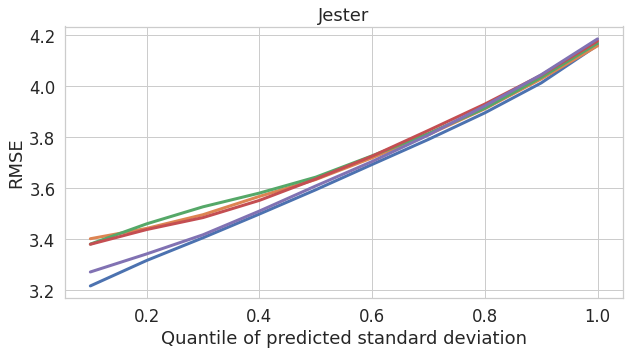

In [15]:
plt.figure(figsize=(10, 5))
# plt.xlim(0, 1)
# plt.ylim(0.6, 0.90)
for j in range(5): 
    # plt.plot(qs, maes_list[j])
    plt.plot(qs, rmses_list[j])
plt.xlabel('Quantile of predicted standard deviation')
plt.ylabel('RMSE')
# plt.legend(['MAE', 'RMSE'])
plt.title('Jester')
plt.show()

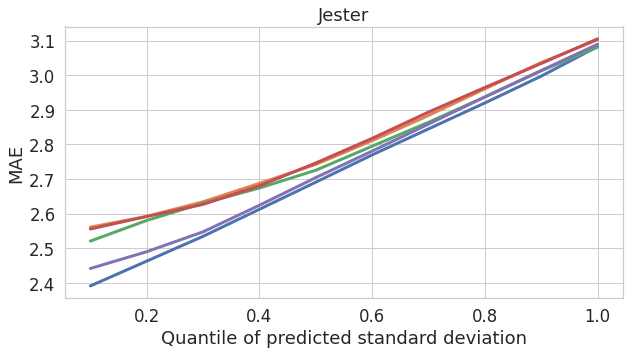

In [16]:
plt.figure(figsize=(10, 5))
# plt.xlim(0, 1)
# plt.ylim(0.6, 0.90)
for j in range(5): 
    plt.plot(qs, maes_list[j])
    # plt.plot(qs, rmses_list[j])
plt.xlabel('Quantile of predicted standard deviation')
plt.ylabel('MAE')
# plt.legend(['MAE', 'RMSE'])
plt.title('Jester')
plt.show()

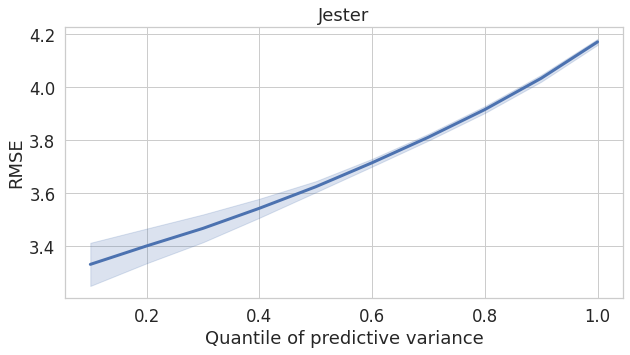

In [12]:
df_plot = pd.DataFrame({'quantile': np.tile(qs, 5), 'rmse': np.concatenate(rmses_list)})

plt.figure(figsize=(10, 5))
# sns.set(font_scale=2)
sns.set(font_scale=1.5, rc={"lines.linewidth": 3})
sns.set_style("whitegrid")
ax = sns.lineplot(x='quantile', y='rmse', data=df_plot, ci='sd')
# plt.axhline(0.824, color='gray', linestyle='--')
ax.set(xlabel='Quantile of predictive variance', ylabel='RMSE', title='Jester')
plt.show()

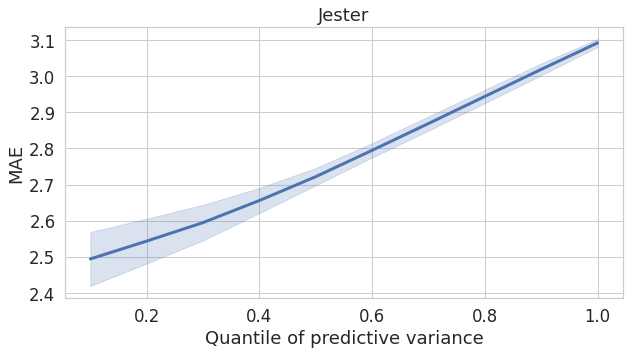

In [13]:
df_plot = pd.DataFrame({'quantile': np.tile(qs, 5), 'mae': np.concatenate(maes_list)})

plt.figure(figsize=(10, 5))
# sns.set(font_scale=2)
sns.set(font_scale=1.5, rc={"lines.linewidth": 3})
sns.set_style("whitegrid")
ax = sns.lineplot(x='quantile', y='mae', data=df_plot, ci='sd')
# plt.axhline(0.824, color='gray', linestyle='--')
ax.set(xlabel='Quantile of predictive variance', ylabel='MAE', title='Jester')
plt.show()

In [17]:
gplvm_rmses = np.zeros((5, 10))
gplvm_maes = np.zeros((5, 10))
for j in range(5): 
    this_res= pd.read_csv('./jester_GPLVM/jester_STD_Q=10_cv'+str(j)+'/mae_rmse_cv'+str(j)+'.csv')
    gplvm_rmses[j] = this_res['RMSE'].values
    gplvm_maes[j] = this_res['MAE'].values

In [18]:
gplvm_rmses_df_plot = pd.DataFrame({'quantile': np.tile(qs, 5), 'rmse': gplvm_rmses.reshape(-1)})
gplvm_maes_df_plot = pd.DataFrame({'quantile': np.tile(qs, 5), 'rmse': gplvm_maes.reshape(-1)})

In [19]:
sns.set()

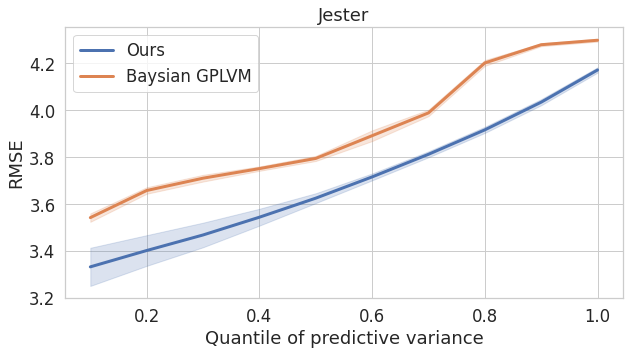

In [20]:
df_plot = pd.DataFrame({'quantile': np.tile(qs, 5), 'rmse': np.concatenate(rmses_list)})

plt.figure(figsize=(10, 5))
# sns.set(font_scale=2)
sns.set(font_scale=1.5, rc={"lines.linewidth": 3})
sns.set_style("whitegrid")
ax = sns.lineplot(x='quantile', y='rmse', data=df_plot, ci='sd')
ax = sns.lineplot(x='quantile', y='rmse', data=gplvm_rmses_df_plot, ci='sd')
# plt.axhline(0.824, color='gray', linestyle='--')
plt.legend(['Ours', 'Baysian GPLVM'])
ax.set(xlabel='Quantile of predictive variance', ylabel='RMSE', title='Jester')
plt.show()

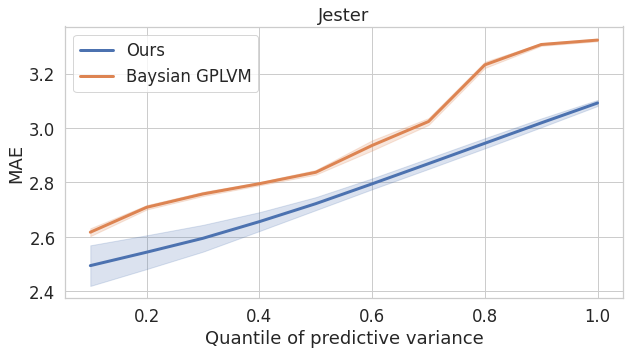

In [21]:
df_plot = pd.DataFrame({'quantile': np.tile(qs, 5), 'mae': np.concatenate(maes_list)})

plt.figure(figsize=(10, 5))
sns.set(font_scale=1.5, rc={"lines.linewidth": 3})
sns.set_style("whitegrid")
ax = sns.lineplot(x='quantile', y='mae', data=df_plot, ci='sd')
ax = sns.lineplot(x='quantile', y='rmse', data=gplvm_maes_df_plot, ci='sd')
# plt.axhline(0.644, color='gray', linestyle='--')
plt.legend(['Ours', 'Baysian GPLVM'])
ax.set(xlabel='Quantile of predictive variance', ylabel='MAE', title='Jester')
plt.show()